In [2]:
import pathlib
import tensorflow as tf
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt 
# import cv2
import numpy as np

In [3]:
img_height = 224
img_width = 224
input_shape = (img_width, img_height, 3)
batch_size = 32
train_dir = pathlib.Path('../input/cacao-augmented-224/training_img/training_img/')
test_dir  = pathlib.Path('../input/cacao-augmented-224/testing_img/testing_img/')
checkpoint_dir = pathlib.Path('./cacao_CAE/checkpoint')
model_dir = pathlib.Path('./cacao_CAE/model.h5')


In [4]:
train_ds = keras.utils.image_dataset_from_directory(
  train_dir,
  labels=None,
    seed=252,
  shuffle=True,
    validation_split=0.2,
    subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)


Found 13272 files belonging to 1 classes.
Using 10618 files for training.


2022-04-11 03:50:12.652040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 03:50:12.783785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 03:50:12.784944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 03:50:12.792210: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [145]:
input_layer = layers.Input(shape=input_shape)
output_layer = layers.Rescaling(scale=1./255, offset=0)(input_layer)
model = keras.Model(input_layer, output_layer)

In [182]:
def reset_model():
    input_layer2 = layers.Rescaling(scale=1./255, offset=0)(input_layer)
    # encoder
    x = layers.Conv2D(84, kernel_size=(7,7))(input_layer2)
    x = layers.LeakyReLU(alpha=0.1)(x)

    x = layers.Conv2D(42, kernel_size=(13,13))(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

    x = layers.Conv2D(42, kernel_size=(9,9))(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

    x = layers.Conv2D(28, kernel_size=(5,5))(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

    x = layers.Conv2D(28, kernel_size=(3,3))(x)   # (14,14,14)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

    x = layers.Conv2D(14, kernel_size=(3,3))(x)   # (7,7,14)
    x = layers.LeakyReLU(alpha=0.1)(x)
#     x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)


    x = layers.Flatten()(x)
    x = layers.Dense(686, activation="relu")(x)
    x = layers.Dense(343, activation="relu")(x)
    x = layers.Dense(112, activation="relu")(x)
    # #latent
    latent = layers.Dense(56, activation="softmax")(x)
    # #decoder
    x = layers.Dense(112, activation="relu")(latent)
    x = layers.Dense(343, activation="relu")(x)
    x = layers.Dense(686, activation="relu")(x)
    x = layers.Reshape((7,7,14))(x)

    x = layers.Conv2DTranspose(14, kernel_size=(3,3), padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(28, kernel_size=(3,3), padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(28, kernel_size=(5,5), padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(42, kernel_size=(9,9), padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(42, kernel_size=(13,13), padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(84, kernel_size=(7,7), padding="same", strides=1)(x)

    output_layer = layers.Conv2D(3, kernel_size=(5,5), padding="same")(x)
    output_layer = layers.Rescaling(scale=255, offset=0)(output_layer)
    model = keras.Model(input_layer, output_layer)
#     model.summary()
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["mse"])
    return(model)
    print("Model reset done!")

In [195]:
model = reset_model()
model.summary()

Model: "model_199"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_289 (Rescaling)    (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_986 (Conv2D)          (None, 218, 218, 84)      12432     
_________________________________________________________________
leaky_re_lu_837 (LeakyReLU)  (None, 218, 218, 84)      0         
_________________________________________________________________
conv2d_987 (Conv2D)          (None, 206, 206, 42)      596274    
_________________________________________________________________
leaky_re_lu_838 (LeakyReLU)  (None, 206, 206, 42)      0         
_________________________________________________________________
max_pooling2d_696 (MaxPoolin (None, 103, 103, 42)      0 

In [206]:
model = keras.models.load_model(model_dir)

In [207]:
epochs = 1
i=0
error=[]
num_batch = 100
for ep in range(epochs):
  print("Epoch",ep+1, "/", epochs)
  for batch in train_ds.take(num_batch):
    i = i+1
    score = model.train_on_batch(x=batch, y=batch, reset_metrics=False, return_dict=False)
    print("batch",i, "--MSE:",score[0])
    error.append(score[0])
    if (np.isnan(score[0])):
        model = reset_model()
        error=[]
        break
    if (i>10):
        if (error[i-1]>error[i-11]) and (error[i-1]>200):
            model = reset_model()
            error=[]
            
            
            

# model.save(model_dir)

Epoch 1 / 1
batch 1 --MSE: 35.47385025024414
batch 2 --MSE: 36.897300720214844
batch 3 --MSE: 37.6720085144043
batch 4 --MSE: 37.21674346923828
batch 5 --MSE: 36.85869598388672
batch 6 --MSE: 36.805660247802734
batch 7 --MSE: 37.1636962890625
batch 8 --MSE: 37.18993377685547
batch 9 --MSE: 37.21012878417969
batch 10 --MSE: 37.125343322753906
batch 11 --MSE: 37.20845031738281
batch 12 --MSE: 36.97394943237305
batch 13 --MSE: 37.14289855957031
batch 14 --MSE: 37.12483596801758
batch 15 --MSE: 37.19853591918945
batch 16 --MSE: 37.3040771484375
batch 17 --MSE: 37.098628997802734
batch 18 --MSE: 37.15245819091797
batch 19 --MSE: 37.075599670410156
batch 20 --MSE: 37.081634521484375
batch 21 --MSE: 37.23392105102539
batch 22 --MSE: 37.06918716430664
batch 23 --MSE: 36.90336990356445
batch 24 --MSE: 36.79898452758789
batch 25 --MSE: 36.813621520996094
batch 26 --MSE: 36.763816833496094
batch 27 --MSE: 36.67739486694336
batch 28 --MSE: 36.644405364990234
batch 29 --MSE: 36.70833969116211
batch

In [209]:
model.save(model_dir)

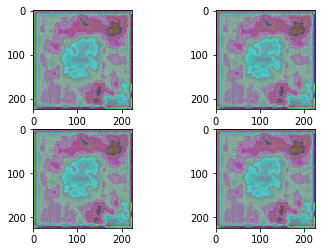

In [208]:
for img in train_ds.take(1):
    image = img
    break

result = model.predict(image, batch_size=None)

for i in range(4):
    img = np.asarray(result[i], dtype="uint8")
    plt.subplot(2,2,i+1)
    plt.imshow(img)

